In [2]:
import mph
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# load client
client = mph.start(cores=1)
client.clear()

In [4]:
# filepath to COMSOL model to load
directory = "D:\COMSOL\Leo\Results"
fp = os.path.join(directory, "SiN_Membrane_PureSIPad_HeightScan.mph")

# load model
model = client.load(fp)

In [5]:
# Access Java API directly
java_model = model.java

mesh_tag = "mesh5"  # obtain via COMSOL
mesh = java_model.component("comp1").mesh(mesh_tag)  # load the mesh

# load data set
dataset_tag = "dset9"
data_set_spec = java_model.result().dataset(dataset_tag)

In [5]:
# We want to set up an evaluation function, following MPh syntax.
# MPH mapping 'evaluations':  'self.model.java.result().numerical()'

# To create an evaluation object, use create(<tag>, "Eval") (or EvalGlobal for global evaluation)
extract_w = java_model.result().numerical().create("w_derivs_arrs", "Eval")

# set properties of evaluation object - page 578 COMSOL docs
extract_w.set("data", "dset9")  # data set used for evaluation
extract_w.set("unit", "um")  # set units for evaluation
# extract_w.set("expr", "w")  # expression to evaluate

<java object 'com.comsol.model.impl.NumericalFeatureImpl'>

In [6]:
# Next, we want to calculate derivatives
# extract_w.set("expr", ["w", "dtang(dtang(w, x), x)", "dtang(dtang(w, y), y)", "dtang(w, x)"])
extract_w.set("expr", ["w", "dtang(w, x)", "dtang(dtang(w, x), x)"])

# calling getData() returns a an array where array[i, j, k] is the expression with index i evaluated
# using solution number j and coordinates data point k, i.e. [expression][solnum][coordinates]
# We can also use getData(<expressionIndex>) if we eg. only care about expression 0.

<java object 'com.comsol.model.impl.NumericalFeatureImpl'>

In [79]:
extract_w.set("outersolnum", "3")  # osn to set
osn = extract_w.getString("outersolnum")

print(osn)

12


In [8]:
w_full = []
deriv_x_full = []
deriv_xx_full = []

for i in range(1, 11):
    
    extract_w.set("outersolnum", str(i))  # osn to set
    print(extract_w.getString("outersolnum"))
    
    # get results data
    displacement_field_z = np.array(extract_w.getData(0))[0] # has same number of elements as the mesh stuff
    print(np.amax(displacement_field_z))
    
    deriv_x = np.array(extract_w.getData(1))[0]
    deriv_xx = np.array(extract_w.getData(2))[0]
    
    w_full.append(displacement_field_z)
    deriv_x_full.append(deriv_x)
    deriv_xx_full.append(deriv_xx)

1
0.00021200000000000003
2
0.00021200000000000003
3
0.00021199999999999998
4
0.000212
5
0.000212
6
0.000212
7
0.000212
8
0.000212
9
0.000212
10
0.00021200000000000003


0.00021200000000000003
0.0 0.0


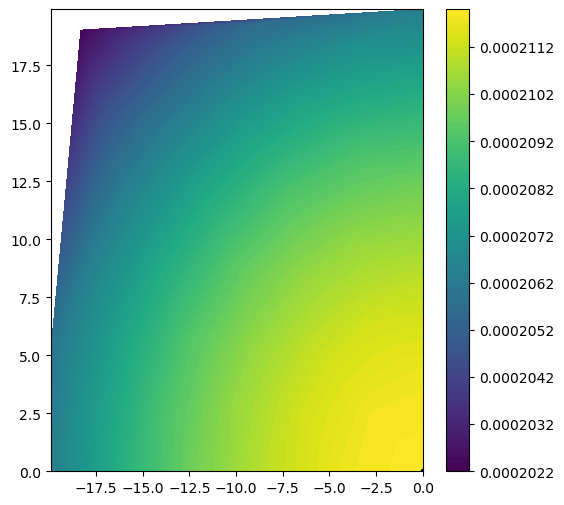

In [21]:
osn = 0
extract_w.set("outersolnum", str(osn+1))

plot_data = w_full[osn]

XX, YY, ZZ = np.array(extract_w.getCoordinates())
print(np.amax(plot_data))

i0 = np.argmax(plot_data)

x0, y0, z0 = XX[i0], YY[i0], ZZ[i0]
print(x0, y0)

# mask_x = np.logical_and(XX < 45.5, XX > 44.5)
# mask_y = np.logical_and(YY > -0.05, YY < 0.05)

mf = np.logical_and(XX > -20, YY < 20)

# mask_z1 = np.logical_and(ZZ < 0.05, ZZ > 0)
# mask_z2 = np.logical_and(ZZ < 0.1, ZZ > 0.05)

# mf = np.logical_and(mask_x, mask_y)
# mf1 = np.logical_and(mf, mask_z1)
# mf2 = np.logical_and(mf, mask_z2)

fig_heatmap, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

triplot1 = ax.tricontourf(XX[mf], YY[mf], plot_data[mf], levels=100)
fig_heatmap.colorbar(triplot1, ax=ax)

ax.scatter(x0, y0, s=10, c="k")

plt.show()

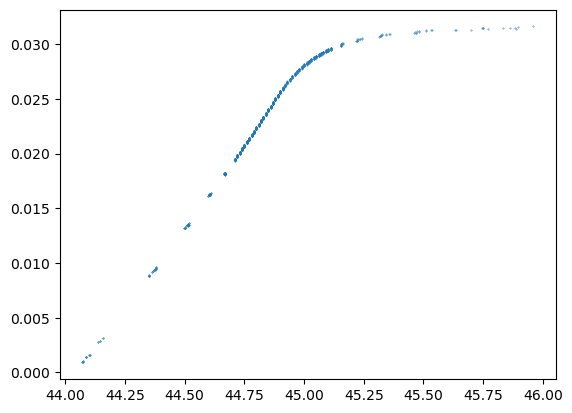

In [87]:
plt.scatter(XX[mf], ZZ[mf], s=0.1)
# plt.ylim(-0.25, 0.25)

In [60]:
# We calculate the total energy for the fundamental mode. 
# For that, we already have an evaluation node in the COMSOL file. Its tag is int1

int_volume = java_model.result().numerical("int1")  # load evaluation node with tag
sol_number = 0

# check if the correct eval expression is loaded
print(int_volume.getString("expr"))

# Just retrieve data, without re-computing it (even though it *should recompute it*)
int_volume_real = np.squeeze(np.array(int_volume.getReal()))[sol_number]
print(int_volume_real)

energy_total = int_volume_real[sol_number]
# print(energy_total)

# Compare with method computeResult()
# int_volume_compute = np.squeeze(np.array(int_volume.computeResult()))
# print(int_volume_compute)

solid.rho*2*(pi*solid.freq)^2*w^2, solid.rho * 2 * (pi * solid.freq)^2 * w^2 / (4.2398E-10 / 2)^2, solid.Wk, w^2 / (4.2398E-10 / 2)^2
[2.28956451e-17 6.34589067e-17 6.34410642e-17 1.19648802e-16
 1.10797957e-16 1.26643516e-16 9.71587511e-17 9.69266395e-17
 2.05795467e-16 1.51064078e-16 2.27092738e-16 2.26813885e-16]


In [7]:
# get regular grid - distance 1 um
x_np = np.linspace(44.5, 45.5, 101, endpoint=True)
y_np = np.array([0.] * 101)
# x_np = np.hstack([seq_geom_neg, seq_geom_pos])
# x_np = np.hstack([seq_outer_neg, seq_outer_pos])

# x_np, y_np = np.meshgrid(x_np, y_np) # extend to grid

# x_np, y_np = x_np.flatten(), y_np.flatten()  # flatten grid - 301^2 entries

z_np = np.array([0.] * len(x_np))

grid_interp = np.array([x_np, y_np, z_np])
print(grid_interp.shape)

(3, 101)


108
36
(36,)


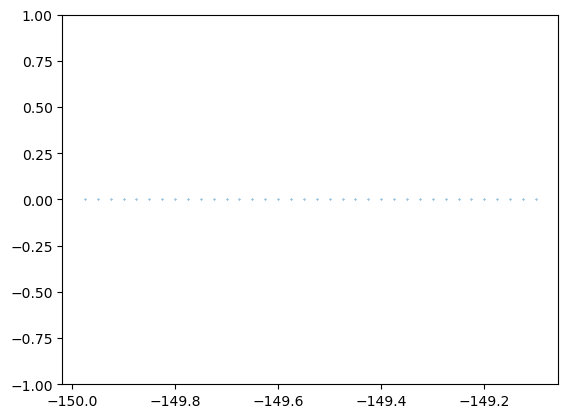

In [41]:
xtm, ytm, ztm = np.array(mesh.getVertex())

# plt.scatter(xtm, ytm, s=0.1)

xm = np.logical_and(xtm > -150, xtm < -148)
ym = np.logical_and(ytm < 0.1, ytm > -0.1)

# print(np.sum(xm), np.sum(ym))

zm = np.logical_and(ztm < 0.026, ztm > 0.024)
# zm = ztm == 0

tm = np.logical_and(xm, ym)
print(np.sum(tm))

tm = np.logical_and(tm, zm)
print(np.sum(tm))

xtm, ytm = xtm[tm], ytm[tm]
ztm = ztm[tm]

plt.scatter(xtm, ytm, s=0.1)
plt.ylim(-1, 1)

print(ytm.shape)

In [42]:
grid_interp = np.array([xtm, ytm, ztm])

In [44]:
# Interpolate data set to evaluate displacement field using mesh coordinates

mesh_vertices_java = mesh.getVertex()

# Choose selection for solution data set - see COMSOL Docs on Interp method
dset_tag = "dset9"  # dset7 has a surface selection - prev. dset5
tag_itp = "mesh_interp"
tag_grid = "grid_interpe"
interpol =  java_model.result().numerical().create(tag_grid, "Interp")
interpol.set("data", dset_tag)
interpol.set("expr", ["w", "dtang(dtang(w, x), x)", "dtang(w, x)", "dtang(dtang(w, x), y)"])

<java object 'com.comsol.model.impl.NumericalFeatureImpl'>

In [45]:
# interpol.setInterpolationCoordinates(mesh_vertices_java) # expects Java type
interpol.setInterpolationCoordinates(grid_interp) # expects Java type

In [17]:
displacement_field_z = np.array(interpol.getData(0))[0] # has same number of elements as the mesh stuff
deriv_xx_itp = np.array(interpol.getData(1))[0]
deriv_x_itp = np.array(interpol.getData(2))[0]
deriv_xy_itp = np.array(interpol.getData(3))[0]

In [51]:
plot_range_ts = np.copy(xtm)
# derivs_z05 = np.copy(derivs_full_xx)

In [46]:
w_full_itp = []
derivs_full_xx = []
derivs_full_x = []

for ii in range(1, 8):
    idx = str(ii)
    interpol.set("outersolnum", idx)
    
    # get results data
    displacement_field_z = np.array(interpol.getData(0))[2] # has same number of elements as the mesh stuff
    deriv_xx_itp = np.array(interpol.getData(1))[2]
    # deriv_x_itp = np.array(interpol.getData(2))[0]
    # deriv_xy_itp = np.array(interpol.getData(3))[0]
    
    derivs_full_xx.append(deriv_xx_itp)
    # derivs_full_x.append(deriv_x_itp)
    w_full_itp.append(displacement_field_z)

print(displacement_field_z.shape)

(36,)


Text(0.5, 1.0, 'wxx [1/m] for (1, 2) mode. \n Z = 0 nm. -1 < Y < 1nm. -150 < X < -148. \n Normalized by surface integral kinetic energy. ')

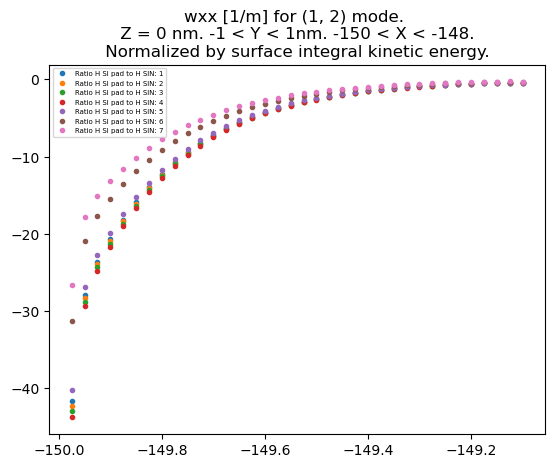

In [49]:
fig_0804 = plt.figure()

vals_normalize = [1.345, 1.307, 1.265, 1.178, 0.977, 0.885, 0.834]

for dxx, norm, ii in zip(derivs_full_xx, vals_normalize, range(1, 8)):
    plt.plot(xtm, dxx / norm, ".", label=f"Ratio H SI pad to H SIN: {ii}")

plt.legend(fontsize=5)
plt.title("wxx [1/m] for (1, 2) mode. \n Z = 0 nm. -1 < Y < 1nm. -150 < X < -148. \n Normalized by surface integral kinetic energy. ")

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

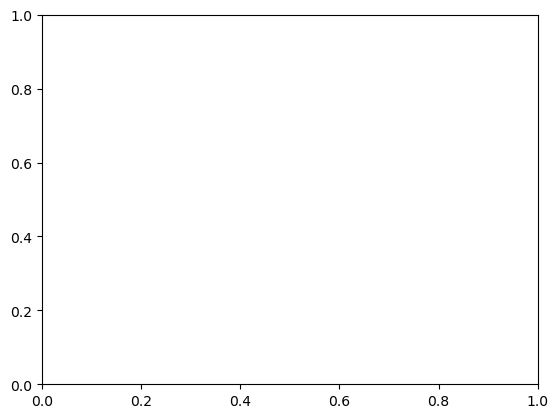

In [114]:
total_curvs = 

fig_2003 = plt.figure()

vals_normalize = [579.968, 552.308, 535.476, 522.411, 517.584, 512.848, 509.644, 507.472, 506.012, 504.240]

for val, norm, ii in zip(total_curvs, vals_normalize, range(1, 11)):
    plt.plot(range(1, 11), val / norm, ".", label=f"{ii}")

# plt.legend()

In [112]:
max_vals = [np.amax(ww) / nn for ww, nn in zip(derivs_full_xx, vals_normalize)]
print(max_vals)

print(max_vals[1] / max_vals[-1])

[0.02563499170976743, 0.02526076795976664, 0.02480464528407073, 0.02445734952779781, 0.023927048544444503, 0.02353943872524213, 0.02319118169372345, 0.022879497853284296, 0.022600726139675297, 0.022387153955933957]
1.1283599518495742


Text(0.5, 1.0, 'Curvature (wxx) at -150 < X < 0. \n Z = 0 [um]. H-SI = x1 H-SiN')

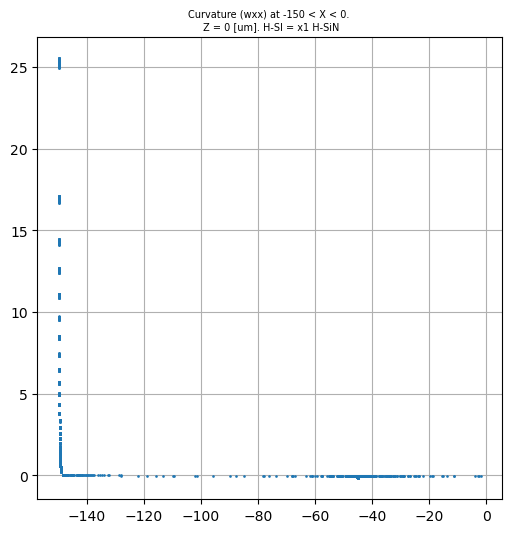

In [18]:
plot_range = np.copy(xtm)
# plot_range2 = np.copy(xtm)

fig_linear, ax2 =  plt.subplots(ncols=1, figsize = (6, 6))

# ax1.grid()
ax2.grid()
# ax1.plot(plot_range, derivs_z05[0], ".", ms=1.8)
ax2.plot(plot_range, deriv_xx_itp, ".", ms=1.8)
# ax1.set_title(f"Curvature transition site. Z = 0.05 [um]. \n H-AL = x1 H-SiN", fontsize=7)
ax2.set_title(f"Curvature (wxx) at -150 < X < 0. \n Z = 0 [um]. H-SI = x1 H-SiN", fontsize=7)
# ax1.set_xlim(44.5, 45.5)
# ax1.set_ylim(-3, 14)
# ax2.set_ylim(-3, 14)

In [70]:
print([len(derivs_z05[i]) for i in range(12)])

print(derivs_z05[-1])

[47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47]
[-0.37602337 -0.40975143 -0.32864509 -0.41050642 -0.2782645  -0.34611475
 -0.23030906 -0.17080696 -0.18723764  0.15167128 -0.05168137  0.52830395
  0.00258122  0.39588907  0.01501727         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan]


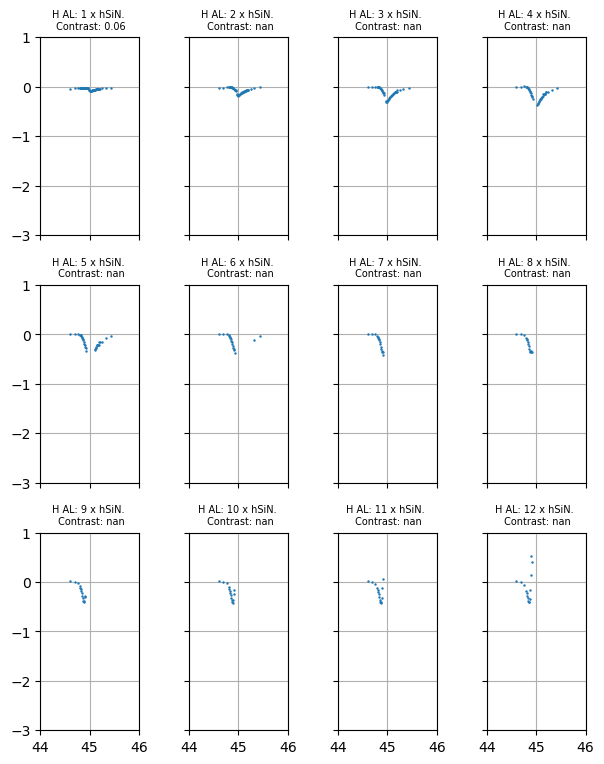

In [42]:
from mpl_toolkits.axes_grid1 import ImageGrid

# fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))
fig = plt.figure(figsize=(12, 9))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 4),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                )

#axes_flat = []
#for ax in axes:
#    for a in ax:
#        axes_flat.append(a)

for ax, im, idxx in zip(grid, derivs_ts, range(1, 13)):
    # print(im)
    # Iterating over the grid returns the Axes.
    # imm = np.arange(100).reshape((10, 10))
    contrast = np.around((np.amax(im) - np.amin(im)), 2)
    ax.plot(plot_range_ts, im, ".", ms=1.5)
    ax.grid()
    ax.set_ylim(-3, 1)
    ax.set_xlim(44, 46)
    ax.set_title(f"H AL: {idxx} x hSiN. \n Contrast: {contrast}", fontsize=7)

# fig.tight_layout()

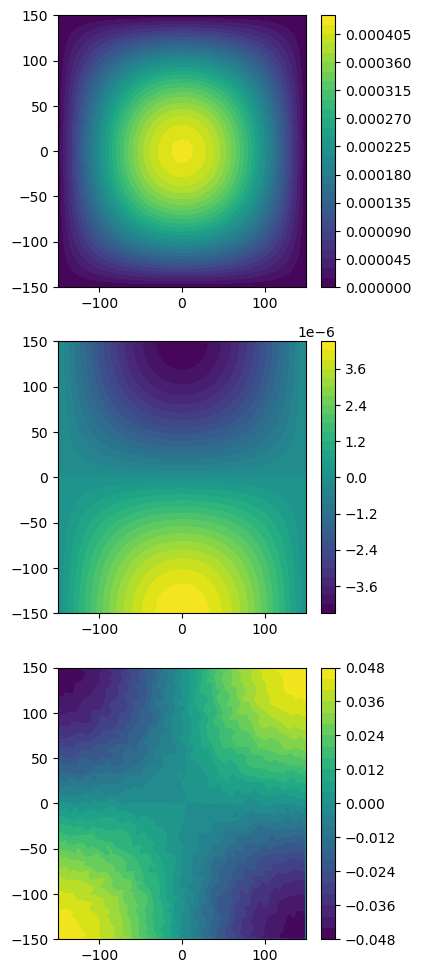

In [51]:
fig_heatmap, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(4, 12))

triplot1 = ax1.tricontourf(x_mask, y_mask, displacement_field_z, levels=30)
fig_heatmap.colorbar(triplot1, ax=ax1)

triplot2 = ax2.tricontourf(x_mask, y_mask, deriv_y, levels=30)
fig_heatmap.colorbar(triplot2, ax=ax2)

triplot3 = ax3.tricontourf(x_mask, y_mask, deriv_xy, levels=30)
fig_heatmap.colorbar(triplot3, ax=ax3)

plt.show()

In [ ]:
# test interpolation coordinates
test_cords = np.array(interpol.getCoordinates())
print(test_cords.shape)

In [ ]:
# Plotting - use triangular plots as simple 3D surface plots require a 2D Z array
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


# Plot the surface
ax.view_init(elev=20., azim=20.)
ax.plot_trisurf(x_np, y_np, deriv_yy, cmap='viridis', edgecolor='none')

In [10]:
# get Q factor
sumCurvature = (deriv_xx + deriv_yy)

# Parameters
h = 50.0e-9
E1 = 200.0e9
E2 = E1/(5.7e10 * h) # See Figure 2 in Villanueva et al.
nu = 0.27

# Integration element 
dx, dy = 1e-6, 1e-6

1e-06


In [11]:
# Formulas from Yeghishe

dW = np.nansum(sumCurvature**2) * dx * dy * h**3 * np.pi * E2 / (12 * (1 - nu**2))  # SI units

intermed = np.nansum(sumCurvature**2 - 2 * (1 - nu) * (deriv_xx * deriv_yy - deriv_xy ** 2))  # SI units
dW_full = dx * dy * h**3 * np.pi * E2 / (12 * (1 - nu**2)) * intermed

print(dW, dW_full)

2.4617683998705698e-23 5.949438407156385e-23


In [12]:
W =  2.8172456e-17  # calculated in COMSOL

Q = (2*np.pi*W/dW) / 1e6 # no units, number -> divide by 1e6 to get millions
Q_full = (2*np.pi*W/dW_full) / 1e6

print(Q, Q_full)

7.190471760693249 2.9752852200880087
